# <p style="text-align: center; text-decoration:underline;">Table of Contents</p>

### [1: Read & Merge Data](#read-merge-data)

    - Read and merge temperature observations counts with station information data.

### [2: Geographical Plotting of Stations](#geo-plotting)

    - Plot the Washington and Oregon stations on map, selecting 5 cluster to chose stations from.

### [2.1: Station Selection](#station-selection)

    - Select from the 5 cluster, the top 4 stations (by number of records) to use.
    
### [3: Examining Potential Stations](#examine-stations)

    - Examine station temperature readings (graphs, tables, etc.) to verify if they are acceptable to use.

### [3.1: Station 36 (Graphing Temp)](#station-36)

    - Examine station 36 by plotting temperature data for each year, a specific month, and specific week to see trends and general patterns.
    

In [1]:
# import general libraries for data exploration and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import seaborn as sns
import datetime as dt
%matplotlib inline

# Geo plotting imports
import geopandas as gpd

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

### Connect to SQL database 
Below will open credentials from saved dictionary file and connect to the MySQL instance. Data can now be queried and loaded directly to the notebook or python file.

In [2]:
# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    print('Credentials Loaded')
    
cnx = mysql.connector.connect(**config) # connection point

Credentials Loaded


### Data Queries
```sql
-- Query to get station counts, "station_count.csv"
SELECT station_id, count(*) as nRecords 
FROM raw_awn_records
GROUP BY station_id
ORDER BY nRecords DESC;

-- Query to get station information (filter for only active stations), "station_info.csv"
SELECT station_id, state, county, active_station, station_latdeg, station_lngdeg, station_elevation
FROM stations_awn
WHERE active_station LIKE 'Y';
```

## Read & Merge Data <a class="anchor" id="read-merge-data"></a>

In [33]:
# Import saved data from SQL Workbench (no longer needed)
# s_count = pd.read_csv("data/station_count.csv")
# s_info = pd.read_csv("data/station_info.csv")

In [3]:
# Query DB to get station ID and number of records
count_q = ("""SELECT station_id, count(*) as nRecords 
              FROM raw_awn_records
              GROUP BY station_id
              ORDER BY nRecords DESC; """)

s_count = pd.read_sql(count_q, cnx)

# Query DB to get station information
info_q = ("""SELECT station_id, state, county, active_station, station_latdeg, station_lngdeg, station_elevation
             FROM stations_awn
             WHERE active_station LIKE 'Y' """)

s_info = pd.read_sql(info_q, cnx)

In [4]:
s_count.head() # 391 observations

,station_id,nRecords
0,1,345485
1,2,345485
2,3,345485
3,4,345485
4,5,345485


In [5]:
s_info.head() # 341 observations

,station_id,state,county,active_station,station_latdeg,station_lngdeg,station_elevation
0,211,WA,Klickitat,Y,45.630430,-121.132360,220.0
1,212,OR,Hood River,Y,45.660529,-121.509670,624.0
2,213,OR,Hood River,Y,45.603099,-121.509583,1128.0
3,215,OR,Wasco,Y,45.171837,-121.289231,2073.0
4,214,OR,Hood River,Y,45.609011,-121.563401,976.0


In [6]:
# Merge data sets to get all info in one DF
stations = pd.merge(s_count, s_info, on='station_id') # 340 observations

In [7]:
stations.head()

,station_id,nRecords,state,county,active_station,station_latdeg,station_lngdeg,station_elevation
0,1,345485,WA,Franklin,Y,46.381860,-119.245640,830.0
1,2,345485,WA,Benton,Y,45.969000,-119.257560,753.0
2,3,345485,WA,Benton,Y,46.040500,-119.308700,1218.0
3,4,345485,WA,Benton,Y,46.213591,-119.500802,1512.0
4,5,345485,WA,Benton,Y,46.143140,-119.460980,1494.0


### Plot Station Data

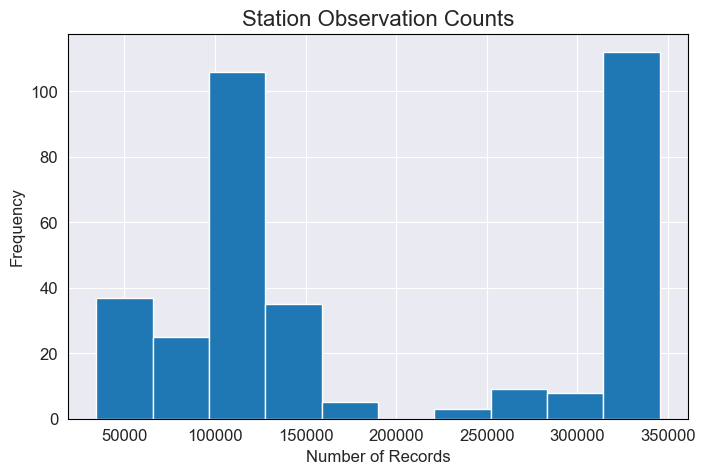

In [8]:
plt.figure(figsize=(8,5))
plt.hist(stations.nRecords)
plt.title('Station Observation Counts')
plt.xlabel('Number of Records')
plt.ylabel('Frequency')
plt.show();

This isn't too important, just looking at the range of the number of oberservations within the merged stations data set. Ideally we'd like to focus on the right half of the chart so that we have the most data possible, but that depends on where the locations are since we want a variet of lat/long.

## Geographical Plotting of Stations <a class="anchor" id="geo-plotting"></a>

The majority of the weather stations are focused in Oregon/Washington, with a select few in Idaho. At the moment, we focus mainly on the OR/WA locations and will discard the idaho locations between lat 43 to 44 and long -117 to -116. Zoomed in below is the same plot, but with lat and long filtered and the station number mapped to its location. The five red boxes are the locations that we want to evaluate.

In [9]:
# Import map shapes
map_o = gpd.read_file('map_shp/oregon/cb_2018_41_bg_500k.shp') # read in oregon state shape
map_w = gpd.read_file('map_shp/washington/cb_2018_53_bg_500k.shp') # read in washington state shape
map_i = gpd.read_file('map_shp/idaho/cb_2018_16_bg_500k.shp') # read in idaho state shape

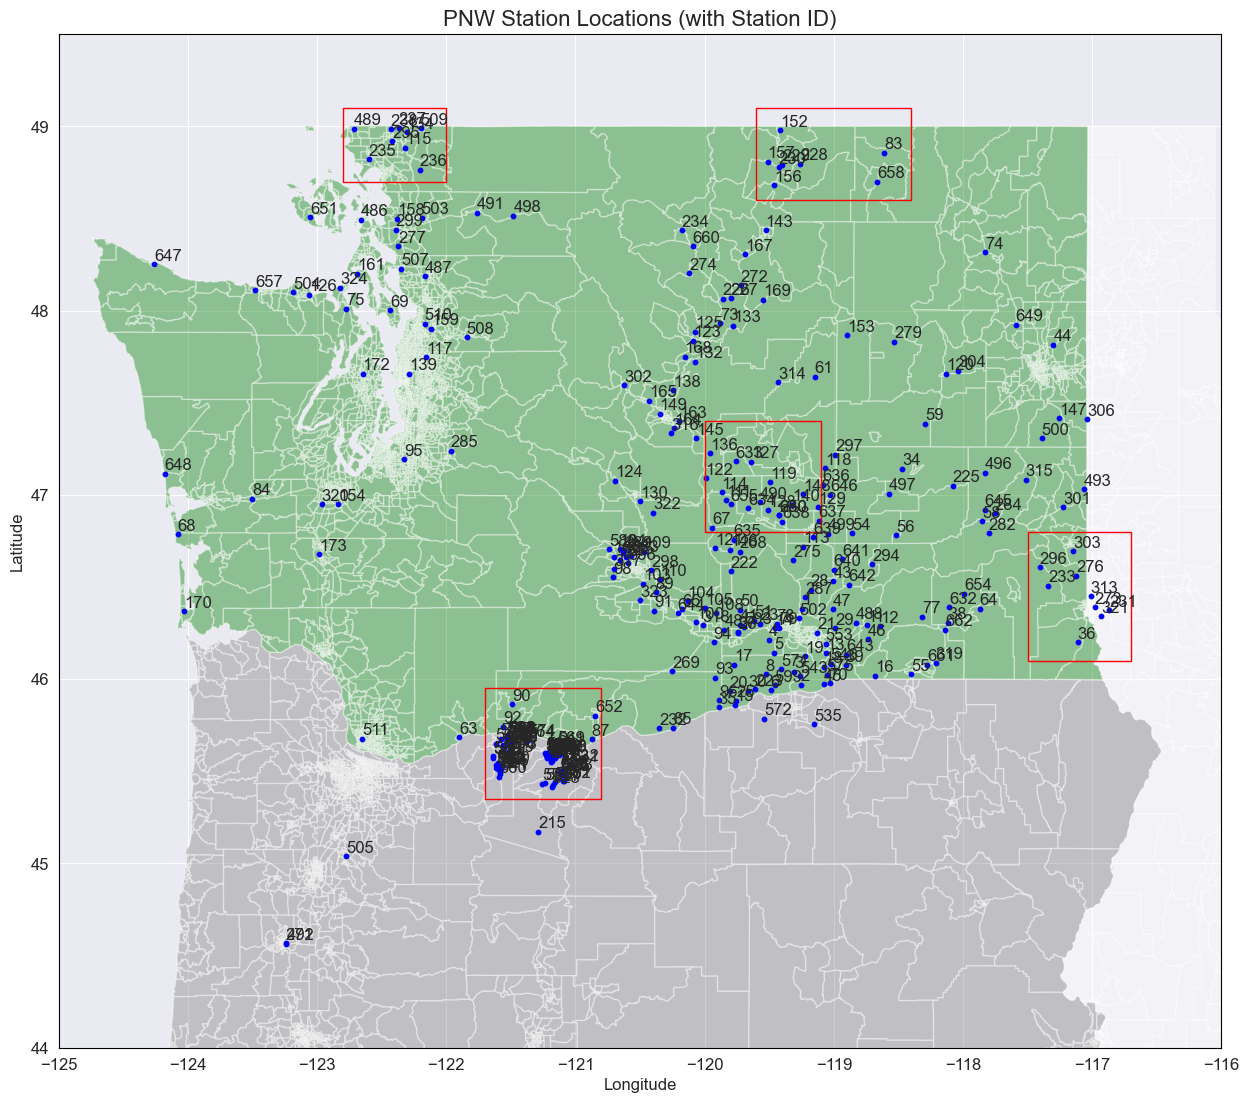

In [10]:
fig, ax = plt.subplots(figsize=(15,15))

map_o.plot(ax=ax, alpha=0.4, color='grey') # oregon (grey)
map_w.plot(ax=ax, alpha=0.4, color='green') # washington (green)
map_i.plot(ax=ax, alpha=0.4, color='white') # idaho (white)
plt.scatter(stations.station_lngdeg, stations.station_latdeg, c='b', s=10)
for i in range(stations.shape[0]):
    if (-125 < stations.station_lngdeg[i] < -116 and 44 < stations.station_latdeg[i] < 49.5):
        plt.text(stations.station_lngdeg[i], stations.station_latdeg[i]+0.02, stations.station_id[i])
plt.xlim(-125, -116)
plt.ylim(44, 49.5)

# Cluster 1 (lat: 48.7 -> 49.1, long: -122.0 -> -122.8)
ax.add_patch(patches.Rectangle((-122.8, 48.7), .8, .4, linewidth=1, 
                               edgecolor='r', facecolor="none")) 

# Cluster 2 (lat: 48.6 -> 49.1, long: -118.4 -> -119.6)
ax.add_patch(patches.Rectangle((-119.6, 48.6), 1.2, .5, linewidth=1, 
                               edgecolor='r', facecolor="none")) 

# Cluster 3 (lat: 45.35 -> 45.95, long: -120.8 -> -121.7)
ax.add_patch(patches.Rectangle((-121.7, 45.35), 0.9, .6, linewidth=1, 
                               edgecolor='r', facecolor="none"))

# Cluster 4 (lat: 46.1 -> 46.8, long: -116.8 -> -117.5)
ax.add_patch(patches.Rectangle((-117.5, 46.1), 0.8, .7, linewidth=1, 
                               edgecolor='r', facecolor="none"))

# Cluster 5 (lat: 46.8 -> 47.4, long: -119.1 -> -120)
ax.add_patch(patches.Rectangle((-120, 46.8), 0.9, .6, linewidth=1, 
                               edgecolor='r', facecolor="none"))

plt.title('PNW Station Locations (with Station ID)')
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.show();

We want to pull data from four corner points and one center point to include the highest variability in the temperature and types of weather patterns that would be present. 

**Current method (implemented below):**

    1. Select five cluster in different points (can be filtered based on lat/long degrees).
    2. Select weather station with highest number of observations.
        - Highest number of total, or highest number of non-null observations?
        - Will want starting timestamp to be at least 2019 or earlier (4+ years of obs.)
    3. Take top 4 from each cluster as potential station.

### Selecting Potential Stations <a class="anchor" id="station-selection"></a>

In [11]:
# Define cluster areas from above graph (these can be changed as needed)
cluster_areas = {
    'C1': {
        'lat': [48.7, 49.1],
        'long': [-122.0, -122.8]
    },
    'C2': {
        'lat': [48.6, 49.1],
        'long': [-118.4, -119.6]
    },
    'C3': {
        'lat': [45.35, 45.95],
        'long': [-120.8, -121.7]
    },
    'C4': {
        'lat': [46.1, 46.8],
        'long': [-116.8, -117.5]
    },
    'C5': {
        'lat': [46.8, 47.4],
        'long': [-119.1, -120]
    }
}

# Empty data frame to hold stations in red boxes above
df = pd.DataFrame()

# Create data frame of potential stations (take top 4 from each - assuming one of these will work)
for c in cluster_areas: # iterate over C1, ..., C5
    cluster = cluster_areas[c] # get lat/long dict
    lat1, lat2 = cluster['lat'][0], cluster['lat'][1] # get latitude
    long1, long2 = cluster['long'][0], cluster['long'][1] # get longitude
    
    # Query data filtered by latitude and longitude values
    q = stations.query(f'{lat1} <= station_latdeg <= {lat2} and {long1} >= station_lngdeg >= {long2}')
    
    q = q.assign(cluster=c) # create column for cluster name
    q = q.sort_values(by=['nRecords'], ascending=False) # sort by number of records
    q = q.iloc[:4] # take top 4 stations (in terms of number of records)
    df = pd.concat([df, q], ignore_index=True) # append to data frame

In [12]:
df[['station_id', 'nRecords', 'state', 'cluster']] # list of potential stations, top 4 from each cluster

,station_id,nRecords,state,cluster
0,115,345485,WA,C1
1,134,345485,WA,C1
2,235,139661,WA,C1
3,236,139661,WA,C1
4,152,345485,WA,C2
5,156,345485,WA,C2
6,157,345485,WA,C2
7,83,224621,WA,C2
8,87,345485,WA,C3
9,92,345485,WA,C3


In [13]:
# print top station from each cluster
[df[df.cluster == x].iloc[0].station_id for x in np.unique(df.cluster.values)]

[115, 152, 87, 36, 111]

# Examining Potential Stations <a class="anchor" id="examine-stations"></a>

### Data Query
```sql
-- Query to get all weather data for select station id
SELECT station_id, tstamp, temp
FROM raw_awn_records r
WHERE r.station_id IN (115, 152, 87, 36, 111);
```

Data for top 5 stations is pulled from above list (this may be changed as stations are re-selected if needed). Currently there are ~1.73 million observations with the 5 stations selected.

In [4]:
# Read in top 5 station data saved from SQL Workbench (no longer used - issue with saved file too)
# station_top5 = pd.read_csv('data/clustered_stations_top_5.csv') # read in data

In [3]:
# Query DB to get timestamp and temp data for top 5 stations above
top5_q = ("""SELECT station_id, tstamp, temp
            FROM raw_awn_records r
            WHERE r.station_id IN (115, 152, 87, 36, 111) """)

s_top_5 = pd.read_sql(top5_q, cnx)

In [4]:
# Print station number, start date, and end date
for x in np.unique(s_top_5.station_id.values):
    print(f"Station {x}:", s_top_5[s_top_5.station_id == x].iloc[[0,-1]].tstamp.values)

Station 36: ['2014-01-01T00:00:00.000000000' '2023-11-08T19:00:00.000000000']
Station 87: ['2014-01-01T00:00:00.000000000' '2023-11-08T19:00:00.000000000']
Station 111: ['2014-01-01T00:00:00.000000000' '2023-11-08T19:00:00.000000000']
Station 115: ['2014-01-01T00:00:00.000000000' '2023-11-08T19:00:00.000000000']
Station 152: ['2014-01-01T00:00:00.000000000' '2023-11-08T19:00:00.000000000']


### Feature Engineering
- Reformat the tstamp
- Need to create Julian Date feature
- Create features for year, date, day, time

In [32]:
# Create 2d array of [['Y M D' , 'Hour Minute'], ...]
t_tup = [str(x).split('T') for x in s_top_5.tstamp.values]

# Create 2d array of [['Y', 'M', 'D'], ...]
ymd = [x[0].split('-') for x in t_tup]

# Create 2d array of [['H', 'Min'], ...]
hm = [x[1].split(':')[:2] for x in t_tup]

#  Create 3 new columns
s_top_5[['year', 'month', 'day']] = ymd

# Create 2 new columns
s_top_5[['hour', 'minute']] = hm 

In [53]:
# Convert columns from string to int
columns_to_convert = ['year', 'month', 'day', 'hour', 'minute']
s_top_5[columns_to_convert] = s_top_5[columns_to_convert].astype(int)

In [54]:
s_top_5

,station_id,tstamp,temp,year,month,day,hour,minute
0,36,2014-01-01 00:00:00,32.0,2014,1,1,0,0
1,36,2014-01-01 00:15:00,32.0,2014,1,1,0,15
2,36,2014-01-01 00:30:00,32.0,2014,1,1,0,30
3,36,2014-01-01 00:45:00,31.6,2014,1,1,0,45
4,36,2014-01-01 01:00:00,31.5,2014,1,1,1,0
...,...,...,...,...,...,...,...,...
1727420,152,2023-11-08 18:00:00,NaN,2023,11,8,18,0
1727421,152,2023-11-08 18:15:00,NaN,2023,11,8,18,15
1727422,152,2023-11-08 18:30:00,NaN,2023,11,8,18,30
1727423,152,2023-11-08 18:45:00,NaN,2023,11,8,18,45


## Station 36 (example) <a class="anchor" id="station-36"></a>
From the top 5 stations selected, look at station 36 as an example of what can be done to estimate parameters. We need to look at:

- Amount of missing data
- Yearly plot of temperature readings
- Estimate min/max/delta_var for 2023 based on subset of years
- Look at seasonal estimation of parameters

We also may want to create new features from breaking up the timestamp feature: day, month, year, julian date (days), time, etc.

In [5]:
# Subset data
s36 = s_top_5[s_top_5.station_id == 36]

s36.iloc[[0, -1]] # 345,484 observations

,station_id,tstamp,temp
0,36,2014-01-01 00:00:00,32.0
345484,36,2023-11-08 19:00:00,30.8


In [6]:
sum(s36.temp.isna()) # number of missing values

880

- There are 345,484 observations for station 233.
- 880 of those temp reading values are NULL.
- Date of recording ranges from January 01, 2014 to November 08, 2023 (~10 years)

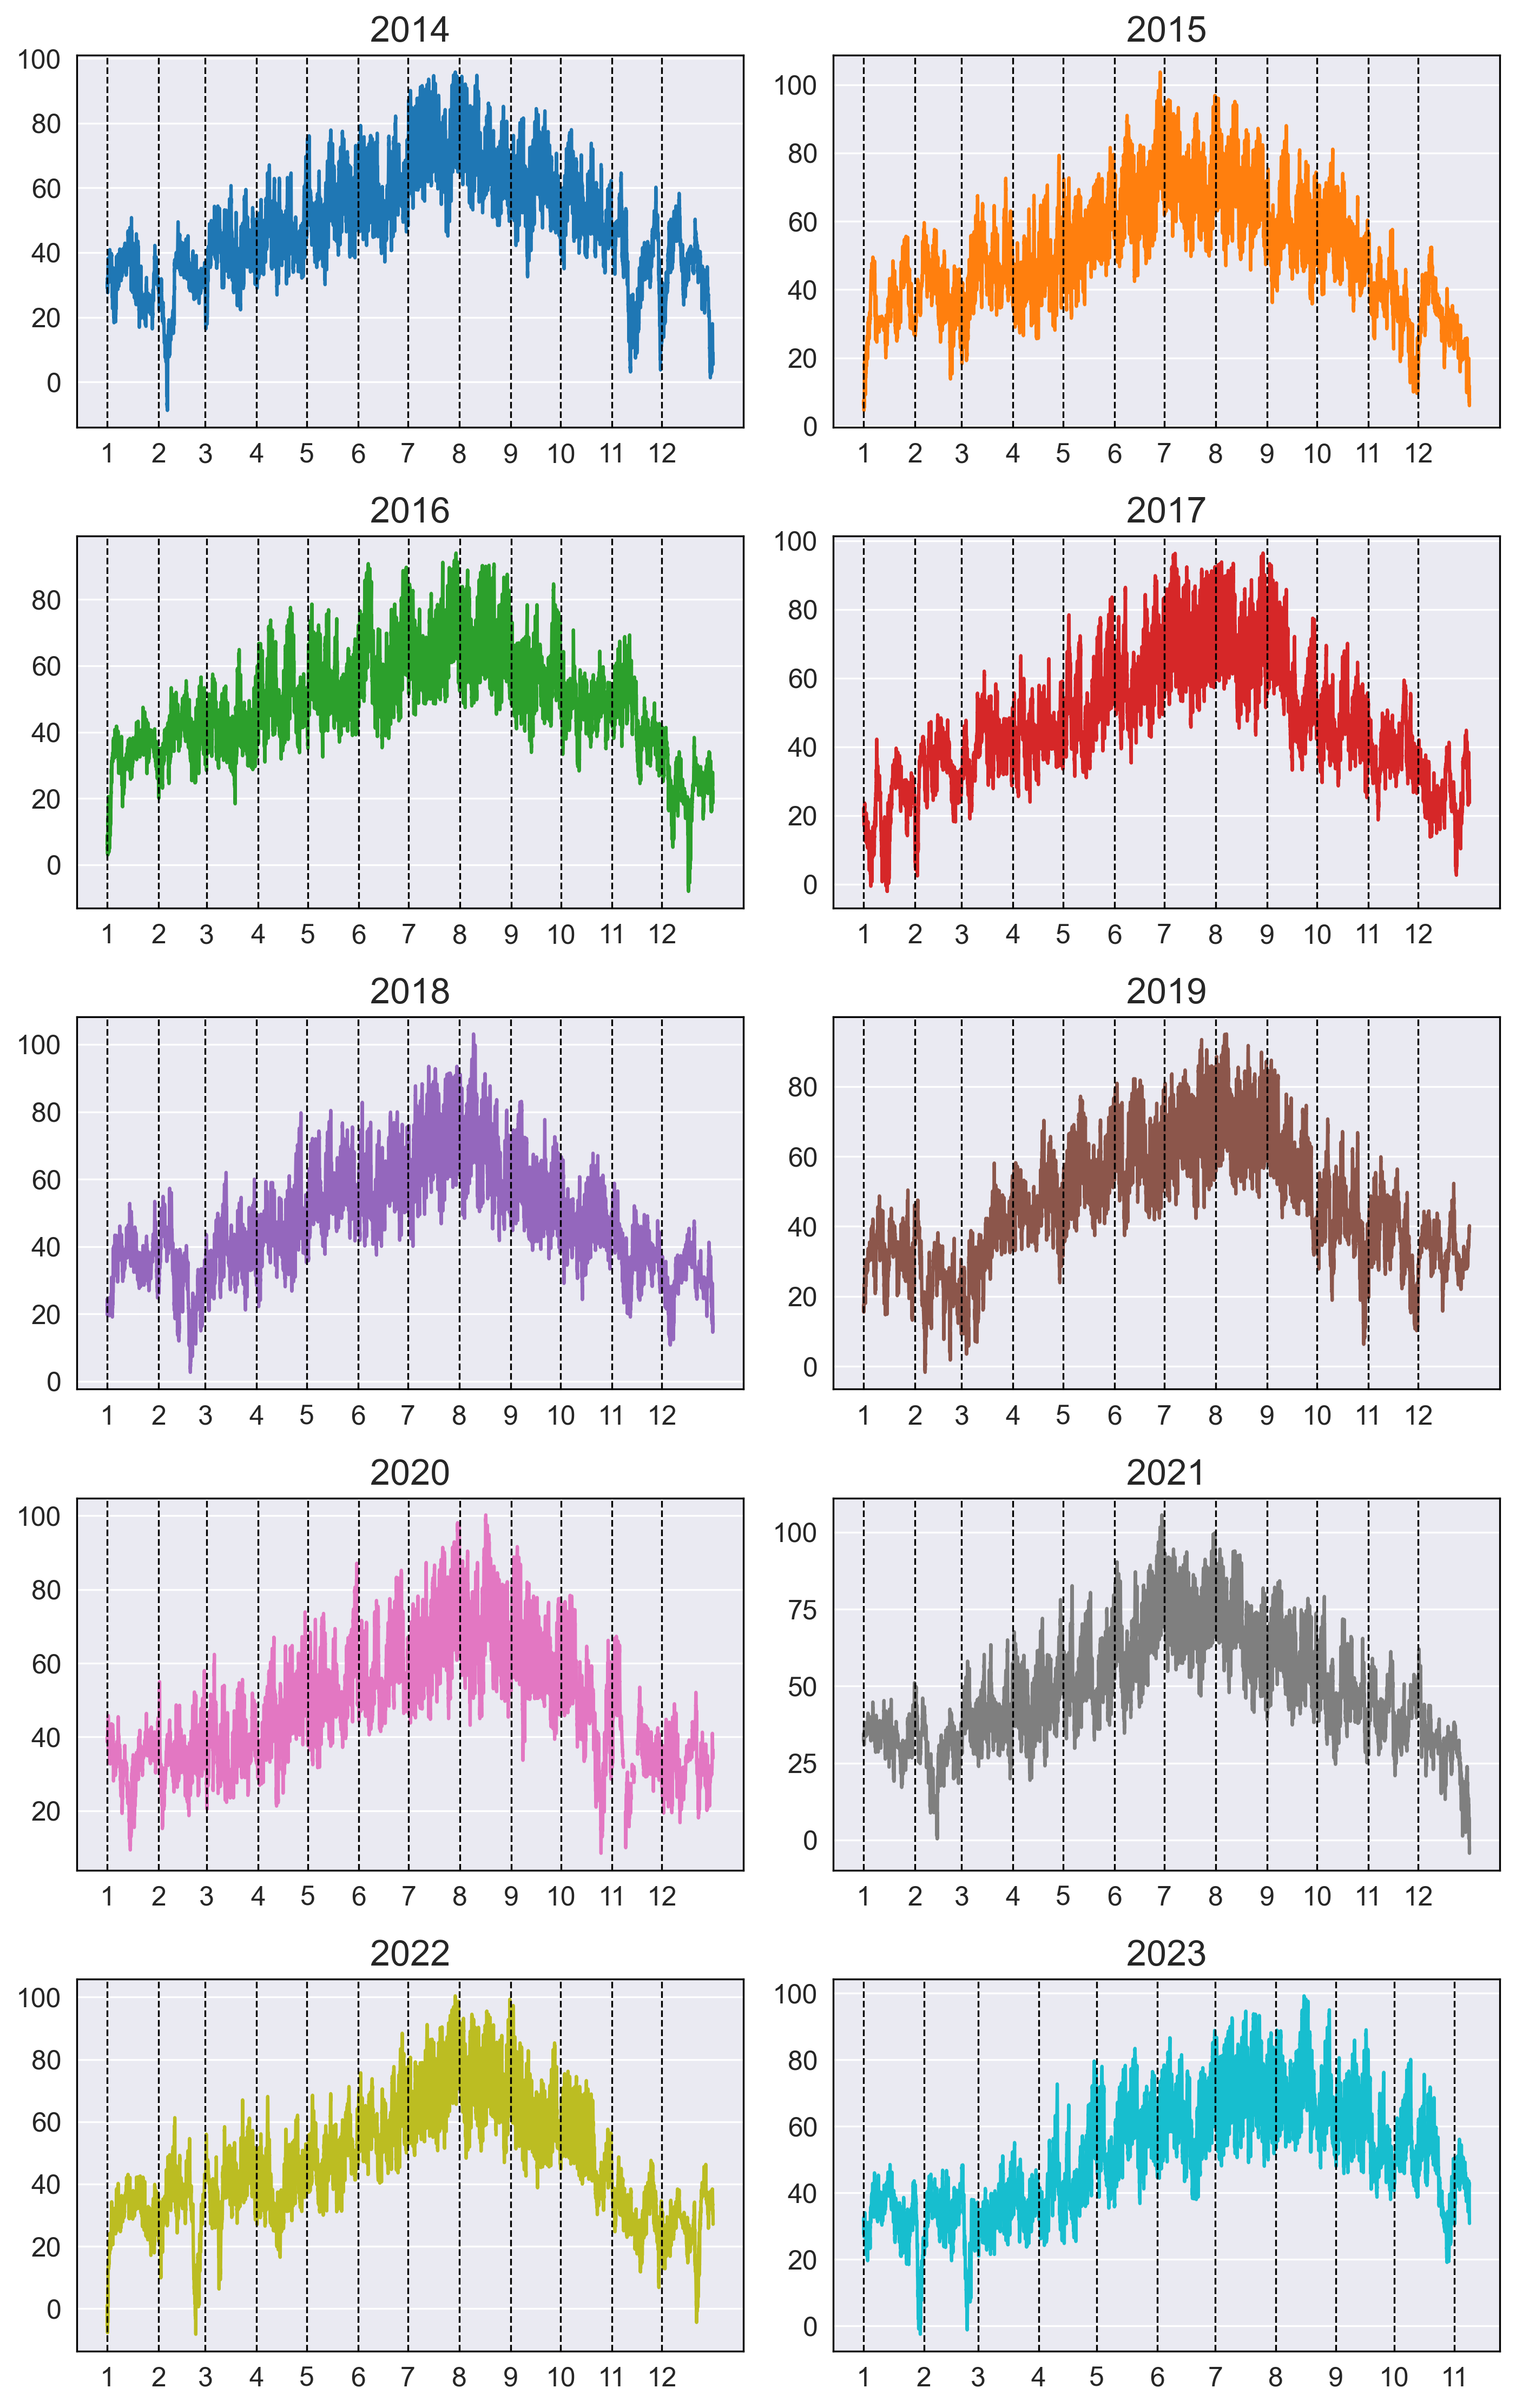

In [87]:
# Subplots of temperature values
fig, axs = plt.subplots(5, 2, figsize=(9.5,15))
axs = axs.flatten()
colors = plt.get_cmap('tab10').colors

for i, y in enumerate(np.unique(s36.year.values)):
    tmp = s36[s36.year == y] # subset weather for certain year
    tmp = tmp.reset_index() # reset index to start at 0
    month_idx = tmp.index[tmp['month'].diff() != 0].values # index values of month
    month_vals = np.unique(tmp.month) # list of months
    average_line = np.nanmean(tmp.temp.values) # compute yearly average (just to compare - not much info here)
    axs[i].plot(tmp.temp.values, color=colors[i]) # plot temp values
    # axs[i].axhline(y=average_line, color='k', linestyle='--', label='Average') # plot average temp
    # axs[i].text(0, 90, f"Avg Temp: {round(average_line, 2)}") # print average temp
    axs[i].set_title(str(y)) # set title
    axs[i].set_xticks(month_idx, month_vals)
    for tick in axs[i].get_xticks():
        axs[i].axvline(tick, color='black', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()

Above is an example of the subplots we want to look at, one for each year. The y-axis represents the temperate, the x-axis is month for which the data is observed. Each vertical line shows the starting date of the month to easily break down and compare across years. This could be one way we can check to make sure that the general pattern follows for each year, such that the parameters the model estimates based on previous years will hold for the predicted year (or season).

#### Single Month (January)

In [58]:
s35_jan_14 = s_top_5.loc[(s_top_5.station_id == 36) & (s_top_5.year == 2014) & (s_top_5.month == 1)]

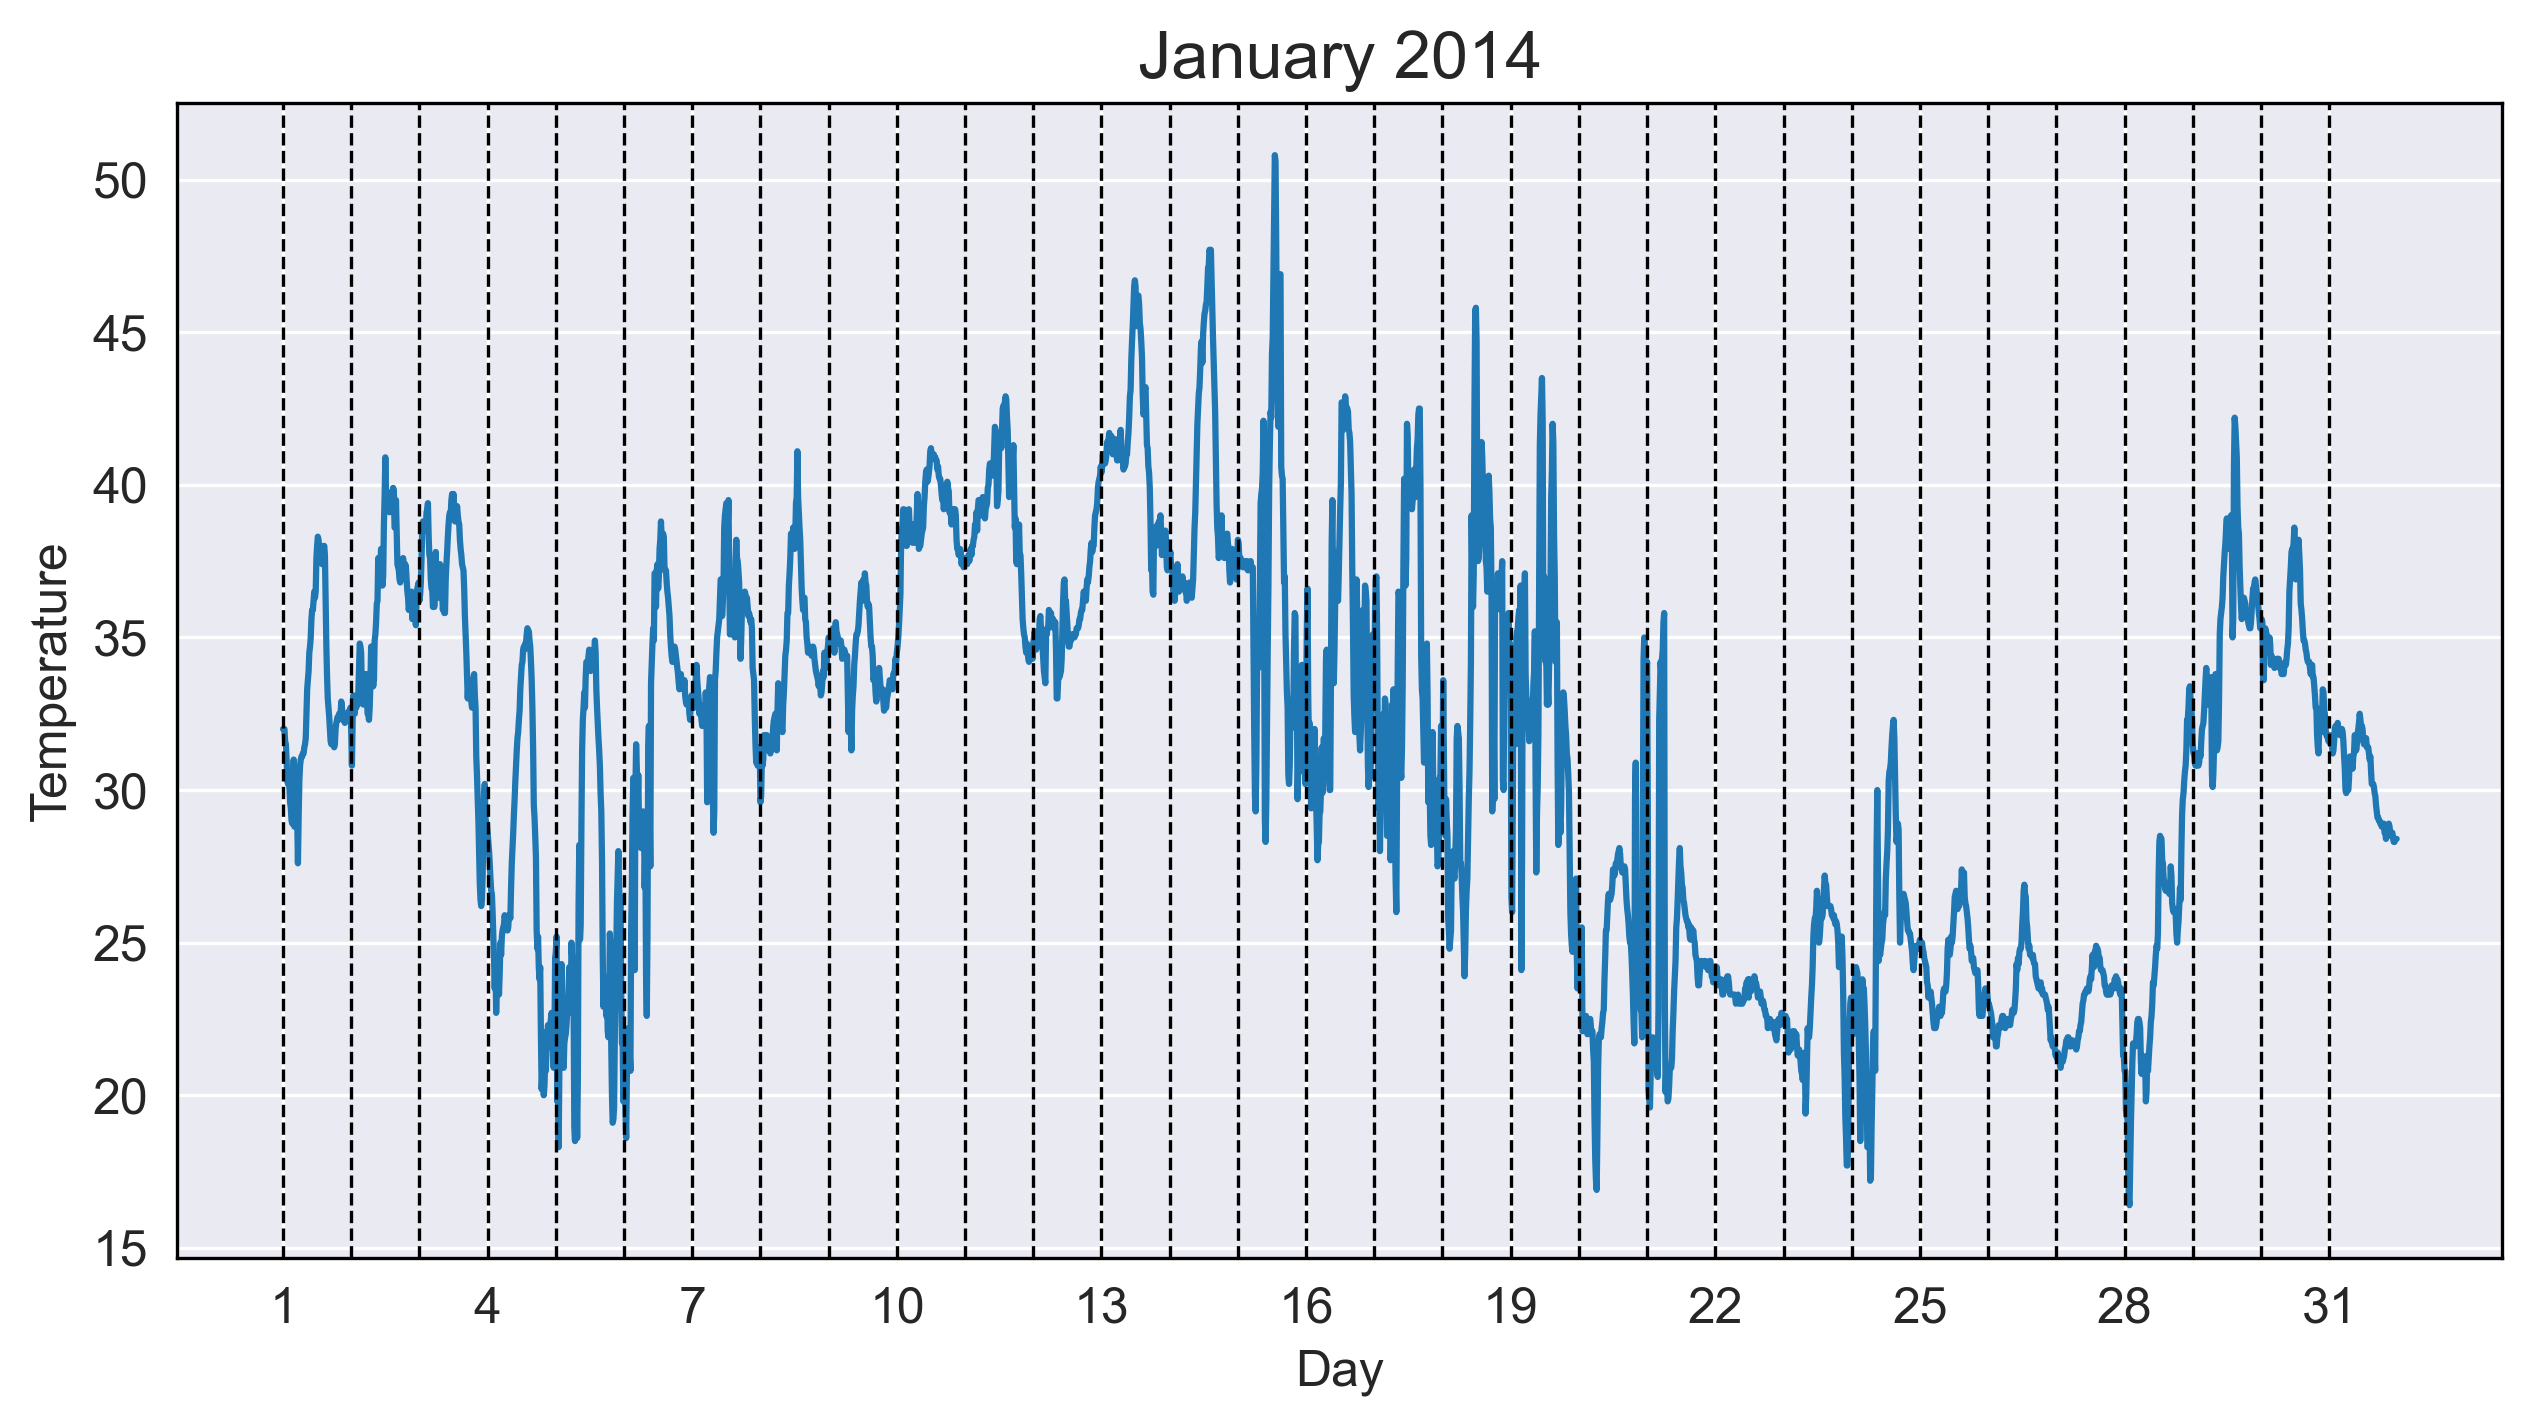

In [73]:
# Get day index of data frame (where it changes)
day_idx = s35_jan_14.index[s35_jan_14['day'].diff() != 0].values

# Get all days (1, ..., last day of month)
day_vals = np.unique(s35_jan_14.day)

# Create plot for single month
plt.figure(figsize=(10,5))
plt.plot(s35_jan_14.temp)
plt.title('January 2014')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.xticks(day_idx[::3], day_vals[::3])
for tick in day_idx:
    plt.axvline(tick, color='black', linestyle='--', linewidth=0.8)

plt.show();

The above is a breakdown for a single month (January 2014), with the temperature on the y-axis and day on the x-axis. I only ticked every 3 days on the x-axis for readability, but all the data is graphed. Each vertical line represents the beginning of that day. It's a bit difficuly to see since it is compressed, so below is a breakdown for the first week of January 2014.

In [89]:
# Subset only first week of January
s35_jan_w1 = s_top_5.loc[(s_top_5.station_id == 36) & (s_top_5.year == 2014) & 
                         (s_top_5.month == 1) & (s_top_5.day <= 7)]

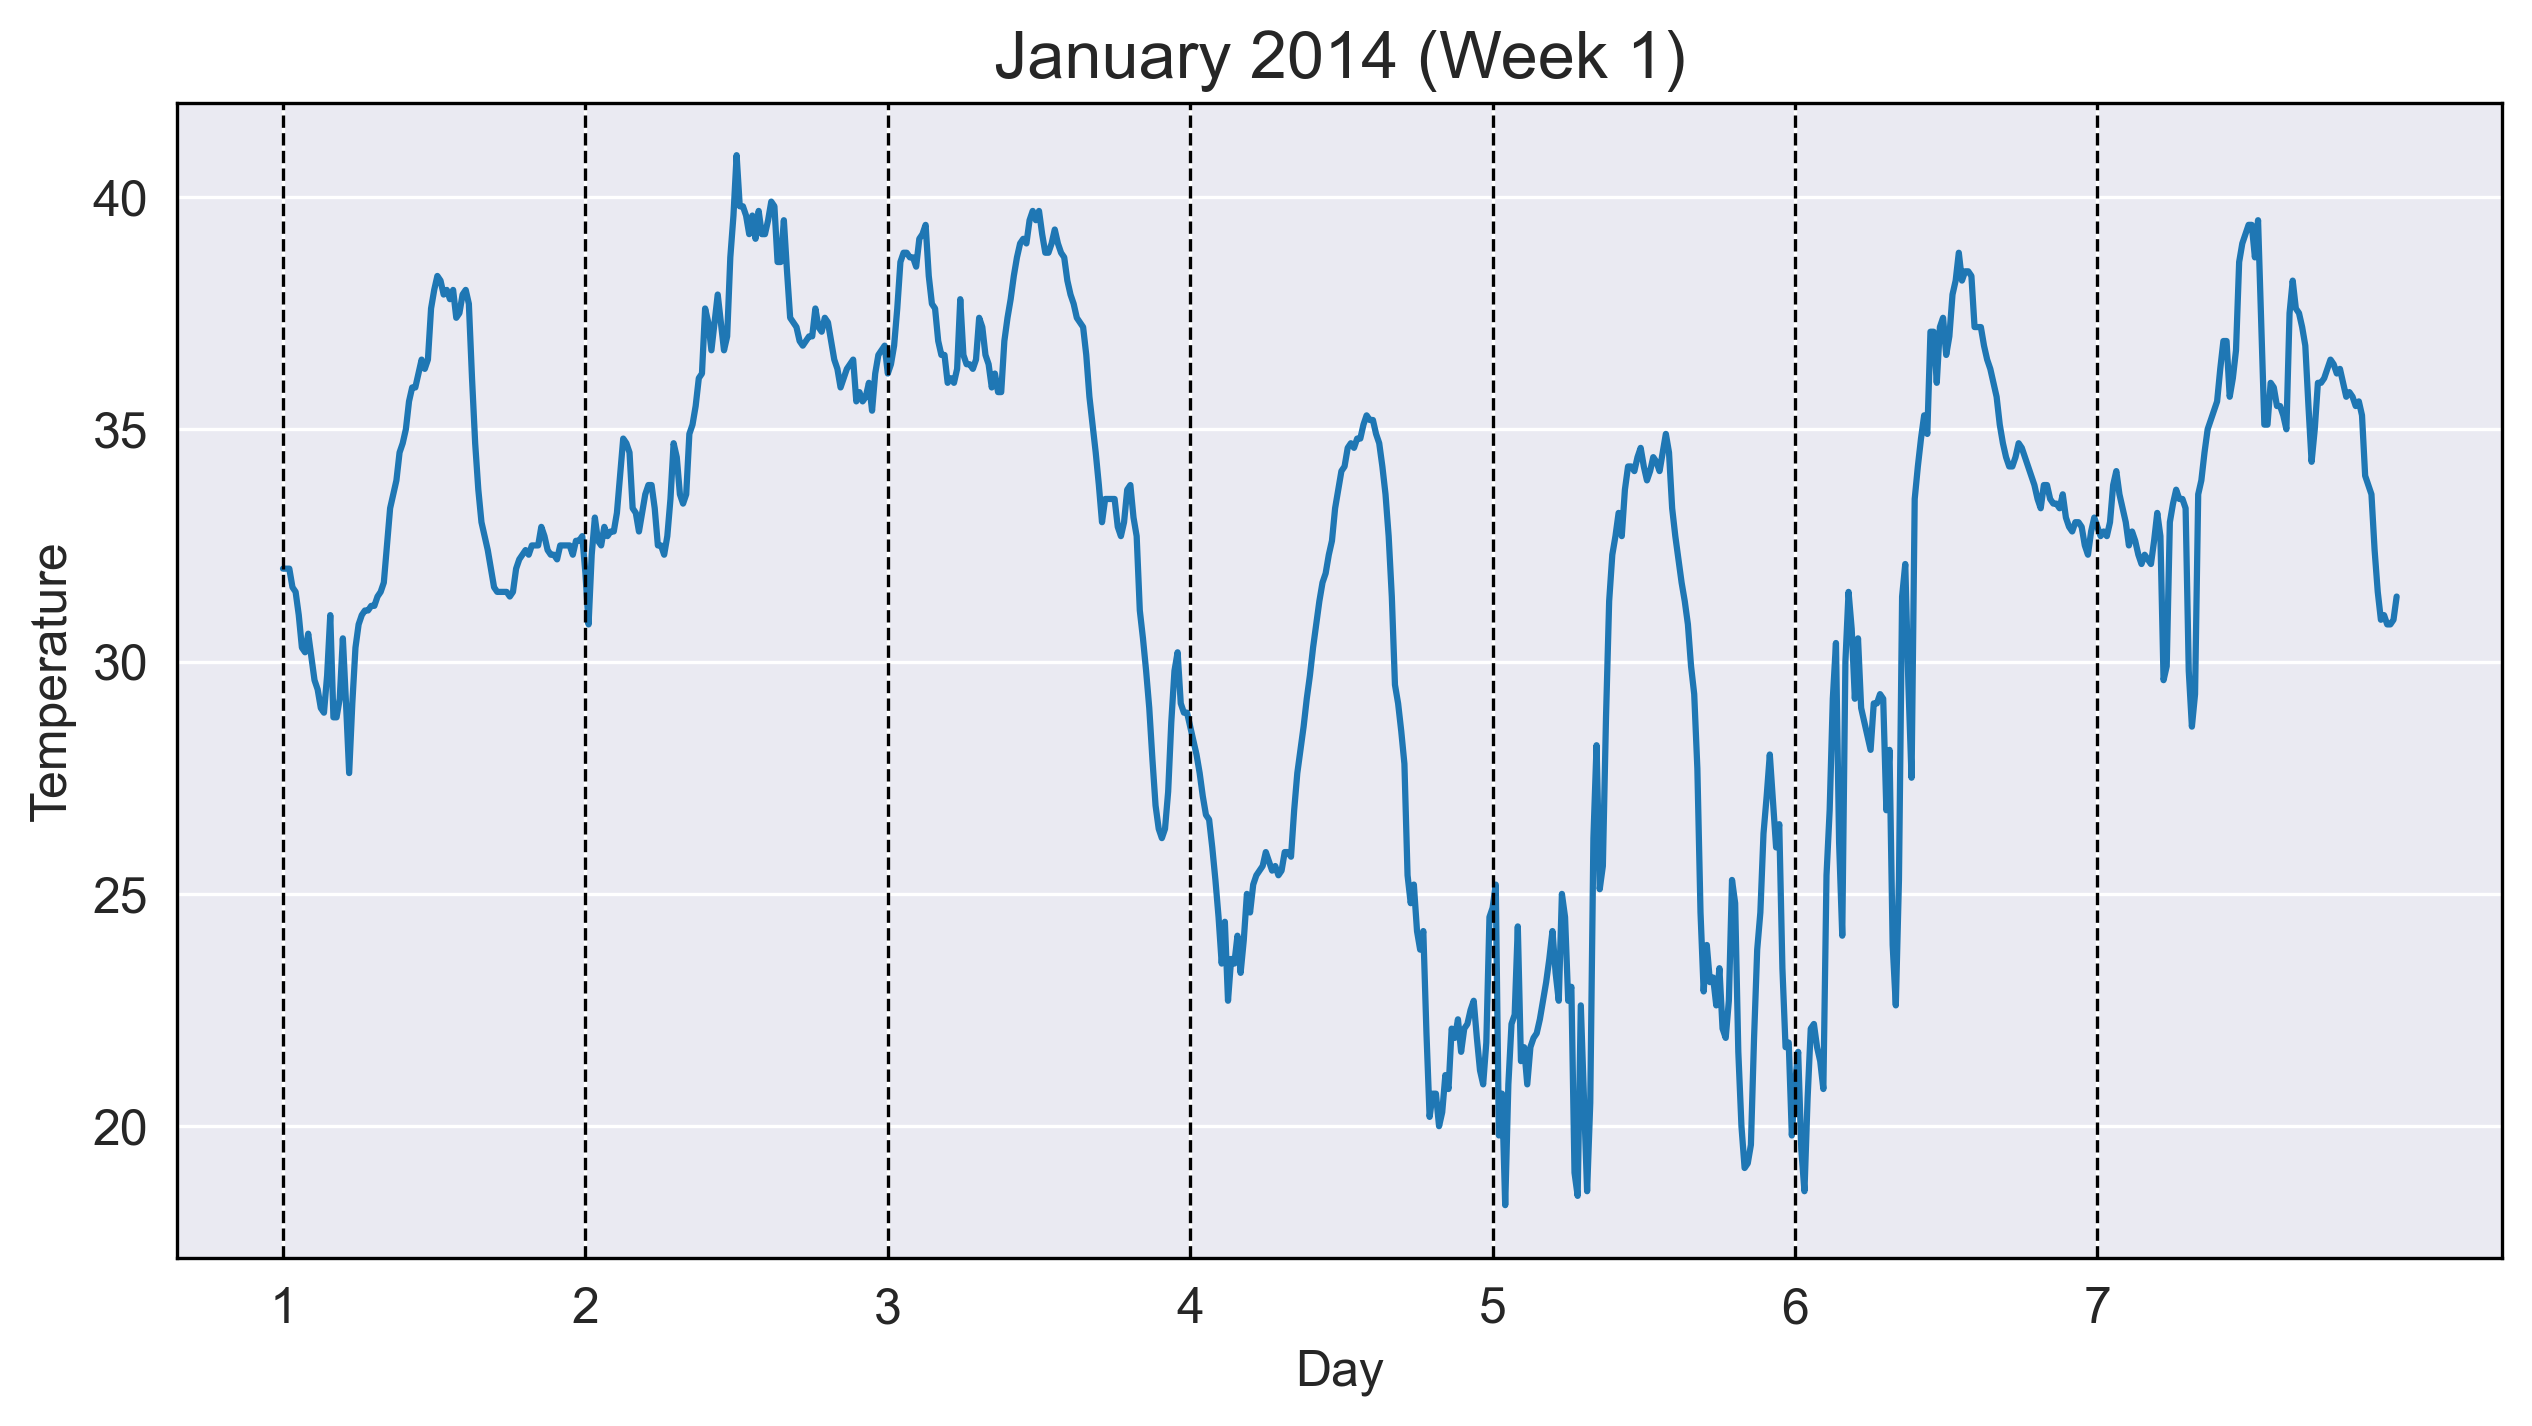

In [92]:
# Get day index of data frame (where it changes)
day_idx = s35_jan_w1.index[s35_jan_w1['day'].diff() != 0].values

# Get all days (1, ..., last day of month)
day_vals = np.unique(s35_jan_w1.day)

# Create plot for single week
plt.figure(figsize=(10,5))
plt.plot(s35_jan_w1.temp)
plt.title('January 2014 (Week 1)')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.xticks(day_idx, day_vals)
for tick in day_idx:
    plt.axvline(tick, color='black', linestyle='--', linewidth=0.8)

plt.show();